## Import Major Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wr
import re
from scipy.signal import hilbert, get_window
from scipy.fft import rfft, rfftfreq
wr.filterwarnings('ignore')

## Importing the Dataset

In [4]:
# Importing the CSV file
df = pd.read_csv('B1_CL4_20.csv',low_memory=False)

## Inputs required for Fatigue Analysis

In [31]:
TIME_COL   = "Time"        # seconds since 1904 (per your dataset)
SIG_COL    = "B3FMR"       # moment signal to analyze
FS         = None          # Hz (set if known). If None, will estimate from timestamps
WIN_SEC    = 600          # fatigue reporting window (e.g., 10 min)

# Mechanics / materials (optional but recommended)
W_SECTION  = None          # [N·m per MPa?] Section modulus to convert moment -> stress (σ = M / W). None = use raw units
SIG_ULT    = None          # [MPa] Ultimate stress for Goodman correction. None = skip Goodman

# S-N curve (Wöhler): N = C / σ_a^m   (σ_a in MPa after Goodman)
SN_C       = 1.0e12        # example constant — tune to your material
SN_m       = 5.0           # typical slope for composites/steels (set appropriately)

## Data Processing

In [33]:
# Convert time column to Date_Time Format
def time_to_datetime(series_sec):
    epoch = pd.Timestamp("1904-01-01 00:00:00Z")
    t = epoch + pd.to_timedelta(series_sec.astype(float), unit="s")
    return t.dt.tz_localize(None)

In [34]:
# Find reversal or turning points in the signal
def find_reversals(x):
    """Return array of turning points (peaks/valleys) as required by ASTM E1049."""
    x = np.asarray(x, dtype=float)
    # remove consecutive duplicates
    x = x[np.insert(np.diff(x) != 0, 0, True)]
    if len(x) < 3:
        return x
    # monotonicity changes
    dx = np.diff(x)
    s  = np.sign(dx)
    turn = np.where(np.diff(s) != 0)[0] + 1
    # Always include first and last
    idx = np.concatenate(([0], turn, [len(x)-1]))
    return x[idx]

In [35]:
# rainflow counting (ASTM 4-point method)
def rainflow_ranges_means(sig):
    """Return list of (range, mean, count) cycles. Half cycles included as 0.5 count."""
    y = find_reversals(sig)
    S = []        # stack of reversals
    cycles = []   # (range, mean, count)

    for v in y:
        S.append(v)
        while len(S) >= 3:
            x1, x2, x3 = S[-3], S[-2], S[-1]
            r1 = abs(x2 - x1)
            r2 = abs(x3 - x2)
            if r1 <= r2:
                rng = r1
                mean = (x1 + x2)/2.0
                cycles.append((rng, mean, 1.0))
                # remove middle element (x2)
                S.pop(-2)
            else:
                break
    # remaining stack -> half cycles
    for i in range(len(S)-1):
        rng = abs(S[i+1] - S[i])
        mean = (S[i+1] + S[i]) / 2.0
        cycles.append((rng, mean, 0.5))
    return cycles

In [36]:
# Converting to Stress if the Section Modulus of the turbine blade is given
def to_stress(range_vals, mean_vals):
    """Convert moment ranges/means to stress (MPa) if W_SECTION given; else pass-through."""
    rng = np.asarray(range_vals, dtype=float)
    mea = np.asarray(mean_vals, dtype=float)
    if W_SECTION is not None:
        rng = rng / W_SECTION
        mea = mea / W_SECTION
    return rng, mea

def goodman_correction(sigma_a, sigma_m, sigma_ult):
    """σa_corrected = σa / (1 - σm/σult). Clip to avoid division by ~0."""
    if sigma_ult is None:
        return sigma_a
    denom = np.maximum(1.0 - (sigma_m / sigma_ult), 1e-6)
    return sigma_a / denom

In [37]:
# 4) damage from SN curve 
def damage_from_cycles(cycles):
    """Return DataFrame of cycles with damage contribution."""
    rng, mea, cnt = map(np.array, zip(*cycles))
    # convert to stress & alternating stress
    rng_s, mea_s = to_stress(rng, mea)
    sigma_a = rng_s / 2.0
    sigma_m = mea_s

    # Goodman (optional)
    sigma_a_corr = goodman_correction(sigma_a, sigma_m, SIG_ULT)

    # cycles to failure: N = C / σ_a^m  => damage = n / N
    Nf = SN_C / np.power(np.maximum(sigma_a_corr, 1e-12), SN_m)
    dmg = np.array(cnt) / Nf

    out = pd.DataFrame({
        "range_raw": rng,
        "mean_raw": mea,
        "sigma_a": sigma_a,
        "sigma_m": sigma_m,
        "sigma_a_corr": sigma_a_corr,
        "count": cnt,
        "Nf": Nf,
        "damage": dmg
    })
    return out

In [38]:
#  per-window fatigue
def fatigue_by_windows(t, x, win_sec=WIN_SEC):
    """Compute rainflow + Miner damage per window over the time series."""
    t = pd.DatetimeIndex(t)
    df = pd.DataFrame({"x": x}, index=t).dropna()
    if df.empty:
        raise ValueError("No data for fatigue.")
    # split by windows using pandas.Grouper
    groups = df.groupby(pd.Grouper(freq=f"{win_sec}s"))
    rows = []
    mats = []  # store matrices for optional aggregation
    for gidx, g in groups:
        if len(g) < 3:  # need at least a few points
            continue
        cycles = rainflow_ranges_means(g["x"].values)
        ddf = damage_from_cycles(cycles)
        D = ddf["damage"].sum()
        rows.append({"window_start": g.index[0], "window_end": g.index[-1], "damage": D, "n_cycles": len(ddf)})
    return pd.DataFrame(rows)

In [39]:
# Expect df with Time + SIG_COL
# 1) time to datetime and estimate sampling rate (only for reference)
t = time_to_datetime(df[TIME_COL])
x = df[SIG_COL].astype(float).values

# optional: (light) detrend to remove very slow drift (keeps cycles)
# x = x - pd.Series(x).rolling(1001, center=True, min_periods=200).mean().to_numpy()

# 2) Rainflow over full record
cycles = rainflow_ranges_means(x)
rf = damage_from_cycles(cycles)
total_damage = rf["damage"].sum()

print(f"Total Miner damage (whole record): {total_damage:.4e}  | number of cycles: {len(rf)}")


Total Miner damage (whole record): 3.2949e-31  | number of cycles: 2364254


# Plots for each window

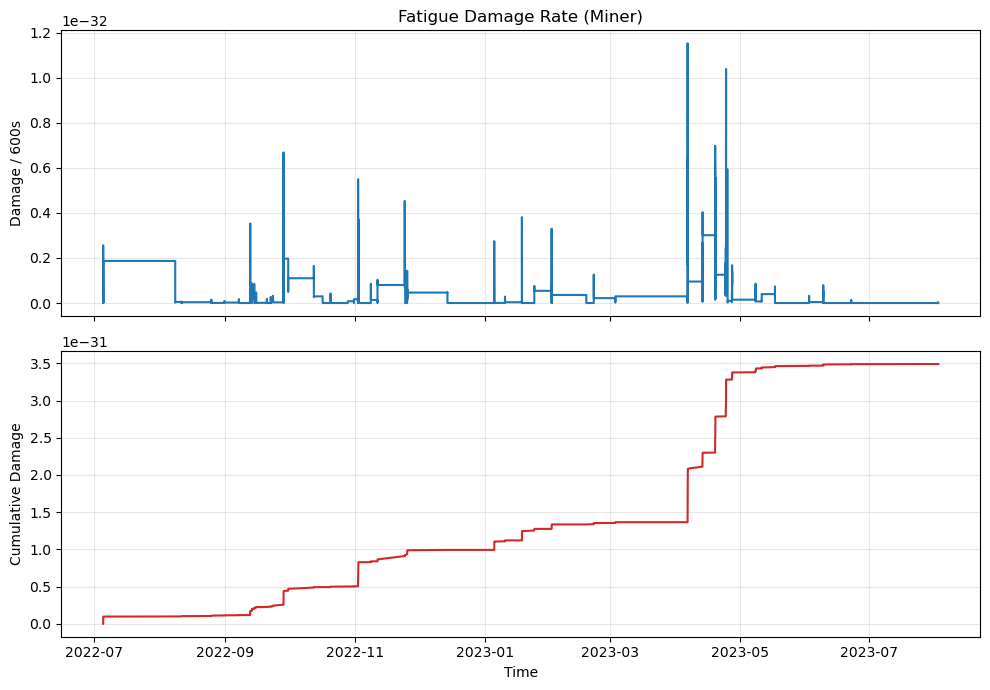

In [54]:
fat = fatigue_by_windows(t, x, win_sec=WIN_SEC)
fat["cum_damage"] = fat["damage"].cumsum()

fig, ax = plt.subplots(2,1, figsize=(10,7), sharex=True)
ax[0].plot(fat["window_start"], fat["damage"], drawstyle="steps-post")
ax[0].set_ylabel(f"Damage / {WIN_SEC}s")
ax[0].grid(alpha=0.3)
ax[0].set_title("Fatigue Damage Rate (Miner)")

ax[1].plot(fat["window_start"], fat["cum_damage"], color="C3")
ax[1].set_ylabel("Cumulative Damage")
ax[1].set_xlabel("Time")
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary Table

In [43]:
summary = pd.DataFrame({
    "total_cycles": [len(rf)],
    "total_damage": [total_damage],
    "avg_damage_per_window": [fat["damage"].mean()],
    "max_damage_window": [fat["damage"].max()],
    "windows": [len(fat)]
})
print(summary)

   total_cycles  total_damage  avg_damage_per_window  max_damage_window  \
0       2364254  3.294892e-31           6.790501e-34       1.153148e-32   

   windows  
0      514  
